<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/start-button-in-igw/sequences/P1C1_BehaviourAsPolicy/P1C1_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is a first test for an upcoming text book on computational neuroscience from an optimization perspective. The book will start with evolution. We are sharing it now to get feedback on what works and what does not and the developments we should do.

# **Part 1 Behaviour, Environments and Optimization: Evolution and Learning**

### **Animals are adapted to their specific environments; their behaviour is best understood within the context of their evolutionary environment.**

### Objective: Part 1 of the book aims to introduce the fundamental concepts of
* ### **environment**, the (statistical) properties of where an organism lives
* ### **behaviour**, the statistics of what the organism does
* ### **optimization**, how learning and evolution shape an organism's behaviour to make it better suited to its environment

This very much is the core of why we are writing this book: we can view pretty much anything happening in the brain (and biology) as being part of a process that brings about improvement in this sense.

___
# Chapter 1.1 Behaviour as a Policy in an Environmental Context

### Objective: This chapter develops examples of how behaviour is described and evaluated in relation to its [goodness](## "This is a very loaded term, to be unpacked carefully later") within a specific environmental niche.

You will learn:
*   What is a policy? A policy is a formalization of behaviour as a function that takes an organism's experiences of their environment as an input and outputs the organism's actions.
*   What is a good policy? The rewards and other environmental signals resulting from the organism's actions in the environment are integrated into a Loss/Objective function to evaluatate, and potentially improve, a policy.
*   What is stochasticity? Both the environment and an organism's behavior can contain random elements. This randomness can pose challenges when evaluating policies as it becomes difficult to determine whether poor outcomes are due to the policy itself or simply bad luck.



___
# **Sequence 1.1.1: Gridworld Introduction**

### Objective: In this sequence, we will create a simple environment-organism system to demonstrate how an organism's **behaviour**, within an **environment**, can be evaluated using **rewards**. We will also see how intelligent behaviour can lead to better outcomes and how **randomness** can make evaluation of behaviour more difficult.

# Setup
Run the following cell to setup and install the various dependencies and helper functions for this sequence.

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**


# pip install dependencies
!pip install ipympl vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab


# import modules
import ipywidgets as widgets
import functools
import threading
from IPython.display import display, clear_output, Markdown
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import time
import asyncio
import logging
import requests
import io
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import jax
import collections
import math
from tabulate import tabulate
from jupyterquiz import display_quiz
from tqdm.notebook import tqdm
from vibecheck import DatatopsContentReviewContainer

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')


# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()
plt.ioff()


# Plotting Functions and Setup
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def printmd(string):
    display(Markdown(string))


def make_grid(num_rows, num_cols, figsize=(7,6)):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for futher use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  ax.spines[['right', 'top']].set_visible(True)
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Labels for major ticks
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)

  # Minor ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)

  ax.xaxis.tick_top()

  # Gridlines based on minor ticks
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)

  # Remove minor ticks
  ax.tick_params(which='minor', bottom=False, left=False)

  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  ax.invert_yaxis()
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()
  return fig, ax


def plot_food(fig, ax, rc_food_loc, food=None):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if food is None:
    food = ax.scatter([], [], s=150, marker='o', color='red', label='Food')
  rc_food_loc = np.array(rc_food_loc, dtype=int)
  #matrix indexing convention is is [row-vertical, col-horizontal]
  #plotting indexing convention is (x-horizontal,y-vertical), hence flip
  food.set_offsets(np.fliplr(rc_food_loc))
  return food


def plot_critter(fig, ax, rc_critter_loc, critter=None):
  """
  Plots "critter" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h', color='blue', label='Critter')
  # matrix indexing convention is is [row-vertical, col-horizontal]
  # plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter


def plot_fov(fig, ax, rc_critter, n_rows, n_cols, radius, has_fov, fov=None):
  """
  Plots a mask on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter: ndarry(int) (row,col) of the critter
    mask: a handle for the existing mask matplotlib Image object if one exists
  Returns:
    a handle for matplotlib Image object of mask, either new if no handle
    was passed in or updated if it was.
  """

  # Initialize mask as a semi-transparent overlay for the entire grid
  mask_array = np.ones((n_rows, n_cols, 4))
  mask_array[:, :, :3] = 0.5  # light grey color
  if has_fov == True:
    mask_array[:, :, 3] = 0.5  # 50% opacity
    # Create arrays representing the row and column indices
    rows = np.arange(n_rows)[:, np.newaxis]
    cols = np.arange(n_cols)[np.newaxis, :]
    # Iterate over each critter location
    dist = np.abs(rows - rc_critter[0]) + np.abs(cols - rc_critter[1])
    # Set the region within the specified radius around the critter to transparent
    mask_array[dist <= radius, 3] = 0
  else:
    mask_array[:, :, 3] = 0

  if fov is None:
    fov = ax.imshow(mask_array, origin='lower', zorder=2)
  else:
    fov.set_data(mask_array)

  return fov


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


# Logic for Gridworld environment


def init_loc(n_rows, n_cols, num, rng=None):
  """
  Samples random 2d grid locations without replacement

  Args:
    n_rows: int
    n_cols: int
    num:    int, wnumber of samples to generate, should
            throw an error ifnum <= n_rows x n_cols

  Optional Keyword Args
    rng:    instance of numpy.random's default random number generator
            (to enable reproducability)

  Returns:
    int_loc:  ndarray(int) of flat indices for the grid
    rc_index: (ndarray(int), ndarray(int)) a pair of arrays the first
      giving the row indices, the second giving the col indices, useful
      for indexing an n_rows by n_cols numpy array
    rc_plotting: ndarray(int) num x 2, same rc coordinates but structured
      in a way that matplotlib likes
  """
  if rng is None:
    rng = np.random.default_rng(seed=SEED)
  int_loc = rng.choice(n_rows * n_cols, num, replace=False)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  rc_plotting = np.array(rc_index).T
  return int_loc, rc_index, rc_plotting




class GridworldBoard():
  """
  A collection methods and parameters of a gridworld game board that
  define the logic of the game.
  Board state is tracked as a triple (pieces, scores, rounds_left)
  pieces: batch_size x n_rows x n_cols np.array
  scores: batch_size np.array
  rounds_left: batch_size np.array

  Pieces are interpreted as:
  1=critter, -1=food, 0=empty

  First dim is batch, second dim row , third is col, so pieces[0][1][7]
  is the square in row 2, in column 8 of the first board in the batch of boards

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """


  def __init__(self, batch_size=1,
               n_rows=7, n_cols=7,
               num_food=10, lifetime=30,
               rng = None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_food = num_food
    self.lifetime = lifetime
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def get_init_board_state(self):
    """Set up starting board using game parameters"""
    #set rounds_left and score
    self.rounds_left = np.ones(self.batch_size) * self.lifetime
    self.scores = np.zeros(self.batch_size)
    # create an empty board array.
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols))
    # Place critter and initial food items on the board randomly
    for ii in np.arange(self.batch_size):
      # num_food+1 because we want critter and food locations
      int_loc, rc_idx, rc_plot = init_loc(self.n_rows,
                                          self.n_cols,
                                          self.num_food+1,
                                          rng=self.rng)
      # critter random start location
      self.pieces[(ii, rc_idx[0][0], rc_idx[1][0])] = 1
      # food random start locations
      self.pieces[(ii, rc_idx[0][1:], rc_idx[1][1:])] = -1
    return(self.pieces.copy(), self.scores.copy(), self.rounds_left.copy())


  def set_state(self, board):
    """ board is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    self.pieces = board[0].copy()
    self.scores = board[1].copy()
    self.rounds_left = board[2].copy()


  def get_state(self):
    """ returns a board state, which is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    return(self.pieces.copy(), self.scores.copy(), self.rounds_left.copy())


  def __getitem__(self, index):
    return self.pieces[index]


  def execute_moves(self, moves, rng=None):
    """
    Updates the state of the board given the moves made.

    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new x coord for each critter
        on each board and the third gives the new y coord.

    Note:
      Assumes that there is exactly one valid move for each board in the
      batch of boards. i.e. it does't check for bounce/reflection on edges,
      or for multiple move made on the same board. It only checks for eating
      food and adds new food when appropriate. Invalid moves could lead to
      illegal teleporting behavior, critter dublication, or index out of range
      errors.
    This assumes the move is valid, i.e. doesn't check for
    bounce/reflection on edges, it only checks eating and adds new food,
    so invalid moves could lead to illegal teleporting behaviour or index out
    of range errors
    """
    if rng is None:
      rng = self.rng
    #critters leave their spots
    self.pieces[self.pieces==1] = 0
    #which critters have food in their new spots
    eats_food = self.pieces[moves] == -1
    # some critters eat and their scores go up
    self.scores = self.scores + eats_food

    num_empty_after_eat = self.n_rows*self.n_cols - self.num_food
    # -1 for the critter +1 for food eaten
    # which boards in the batch had eating happen
    g_eating = np.where(eats_food)[0]
    if np.any(eats_food):
      # add random food to replace what is eaten
      possible_new_locs = np.where(np.logical_and(
          self.pieces == 0, #the spot is empty
          eats_food.reshape(self.batch_size, 1, 1))) #food eaten on that board
      food_sample_ = rng.choice(num_empty_after_eat, size=np.sum(eats_food))
      food_sample = food_sample_ + np.arange(len(g_eating))*num_empty_after_eat
      assert np.all(self.pieces[(possible_new_locs[0][food_sample],
                                 possible_new_locs[1][food_sample],
                                 possible_new_locs[2][food_sample])] == 0)
      #put new food on the board
      self.pieces[(possible_new_locs[0][food_sample],
                   possible_new_locs[1][food_sample],
                   possible_new_locs[2][food_sample])] = -1
    # put critters in new positions
    self.pieces[moves] = 1.0
    self.rounds_left = self.rounds_left - 1
    assert np.all(self.pieces.sum(axis=(1,2)) == ((self.num_food * -1) + 1))


  def get_legal_moves(self):
    """
    Identifies all legal moves for the critter, taking into acount
    bouncing/reflection at edges,

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offstet on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    #apply all possible offsets to each game
    moves = np.stack([
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0,  1, 0])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, -1, 0])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, 0,  1])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, 0, -1])]*self.batch_size).T]).swapaxes(0,2)

    #check bounces at boundaries
    moves[:,1,:] = np.where(moves[:,1,:] >=
                            self.n_rows, self.n_rows-2, moves[:,1,:])
    moves[:,2,:] = np.where(moves[:,2,:] >=
                            self.n_cols, self.n_cols-2, moves[:,2,:])
    moves[:,1,:] = np.where(moves[:,1,:] < 0, 1, moves[:,1,:])
    moves[:,2,:] = np.where(moves[:,2,:] < 0, 1, moves[:,2,:])
    return moves


  def get_perceptions(self, radius):
    """
    Generates a vector representation of of the critter perceptions, oriented
    around the critter. get_precept_filter is used to get a canonical version
    of the board with unknonw positions ocluded

    Args:
      radius: int, how many grid squared the critter can see around it
        using L1  (Manhattan/cityblock) distance

    Returns:
      A batch_size x 2*radius*(radius+1) + 1, giving the values
      of the percept reading left to right, top to bottom over the board,
      for each board in the batch
    """
    # define the L1 ball mask
    diameter = radius*2+1
    mask = np.zeros((diameter, diameter), dtype=bool)
    mask_coords = np.array([(i-radius, j-radius)
      for i in range(diameter)
        for j in range(diameter)])
    mask_distances = cdist(mask_coords, [[0, 0]],
                           'cityblock').reshape(mask.shape)
    mask[mask_distances <= radius] = True
    mask[radius,radius] = False  # exclude the center

    # pad the array
    padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
     (radius, radius)), constant_values=-2)

    # get locations of critters
    critter_locs = np.argwhere(padded_arr == 1)

    percepts = []
    for critter_loc in critter_locs:
      b, r, c = critter_loc
      surrounding = padded_arr[b, r-radius:r+radius+1, c-radius:c+radius+1]
      percept = surrounding[mask]
      percepts.append(percept)
    return(np.array(percepts))




class GridworldGame():
  """
  A collection methods and parameters of a gridworld game that allow
  for interaction with and display of GridwordlBoard objects.
  """
  square_content = {
      -1: "X", #Food
      +0: "-", #Nothing
      +1: "O"  #Critter
      }


  def get_square_piece(self, piece):
    return GridworldGame.square_content[piece]


  def __init__(self, batch_size, n_rows, n_cols,
               num_food, lifetime, rng=None):
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_food = num_food
    self.lifetime = lifetime
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns a tuple giving current state of the game
    """
    # current score, and rounds left in the episode
    b = GridworldBoard(self.batch_size, self.n_rows, self.n_cols,
                       self.num_food, self.lifetime, rng=self.rng)
    return b.get_init_board_state()


  def get_board_size(self):
    """Shape of a sinlge board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)


  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only  2-4 of
    these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to g,x,y coordinate indexes of board locations
    """
    return self.n_rows * self.n_cols


  def get_batch_size(self):
    """
    Returns the number of actions, only 2-4 of these will ever be valid.
    Actions correspond to integer indexes of board locations,
    moves to x,y indexes of board locations
    """
    return self.batch_size


  def string_rep(self, board, g):
    """ A bytestring representation board g's state in the batch of boards"""
    return board[0][g].tobytes() + board[1][g].tobytes() + board[2][g].tobytes()


  def string_rep_readable(self, board, g):
    """ A human readable representation of g-th board's state in the batch"""
    board_s = "".join([self.square_content[square] for row in board[0][g]
                       for square in row])
    board_s = board_s + '_' + str(board[1][g])
    board_s = board_s + '_' + str(board[2][g])
    return board_s


  def get_scores(self, board):
    return board[1].copy()


  def get_rounds_left(self, board):
    return board[2].copy()


  def display(self, board, g):
    """Dispalys the g-th games in the batch of boards"""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for c_ in range(self.n_cols):
      print(c_, "|", end="")    # Print the row
      for r_ in range(self.n_rows):
        piece = board[0][g,c_,r_]    # Get the piece to print
        print(GridworldGame.square_content[piece], end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board[2][g]))
    print("Score: " + str(board[1][g]))


  def get_critter_rc(self, board, g):
    return np.squeeze(np.array(np.where(board[0][g]==1)))


  def plot_board(self, board, g,
                 fig=None, ax=None, critter=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war
                 radius=2,
                 figsize=(6,5)):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board[0].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize)
    rc_critter = self.get_critter_rc(board, g)

    if critter is None:
      critter = plot_critter(fig, ax, rc_critter)
    else:
      critter = plot_critter(fig, ax, rc_critter, critter)
    rc_food_index = np.array(np.where(board[0][g] == -1))
    rc_food_plotting = np.array(rc_food_index).T

    if food is None:
      food = plot_food(fig, ax, rc_food_plotting)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food)

    if fov is None:
      fov = plot_fov(fig, ax, rc_critter, n_rows, n_cols,
                     radius, has_fov)
    else:
      fov = plot_fov(fig, ax, rc_critter, n_rows, n_cols,
                     radius, has_fov, fov)

    if legend_type == 'included':
      fig.legend(loc = "outside right upper")
      fig.canvas.draw()
      return fig, ax, critter, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(2,2), layout='constrained')
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center')
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter, food, fov


  def get_valid_actions(self, board):
    """
    A Helper function to translate the g,x,y, tuples provided the
    GridworldBoard.get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    batch_size, n_rows, n_cols = board[0].shape
    b = GridworldBoard(batch_size, n_rows, n_cols,
                       self.num_food, self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    legal_moves =  b.get_legal_moves()
    valids = np.zeros((batch_size, n_rows * n_cols))
    for ii, g in enumerate(legal_moves[:,1:,:]):
      for x,y in zip(g[0],g[1]):
        valids[ii, x*self.n_cols+y] = 1
    return valids


  def display_moves(self, board, g):
    """Dispaly possible moves for the g-th games in the batch of boards"""
    batch_size, n_rows, n_cols = board[0].shape
    A=np.reshape(self.get_valid_actions(board)[g], (n_rows, n_cols))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for y in range(self.n_cols):
      print(y, end=" ")
    print("")
    print("-----------------------")
    for y in range(self.n_cols):
      print(y, "|", end="")    # Print the row
      for x in range(self.n_rows):
        piece = A[y][x]    # Get the piece to print
        print(GridworldGame.square_content[piece], end=" ")
      print("|")
    print("-----------------------")


  def get_next_state(self, board, actions, a_indx=None):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: list of integer indexes of critter's new board positions
      a_indx: list of integer indexes indicating which actions are being taken
        on which boards in the batch

    Returns:
      a board tiple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parellel

    """
    batch_size, n_rows, n_cols = board[0].shape
    if board[2][0] <= 0:
      # assumes all boards in the batch have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
      b = GridworldBoard(len(actions), n_rows, n_cols,
                         self.num_food, self.lifetime,
                         rng=self.rng)
      if a_indx is None:
        # just one move on each board in the batch
        assert batch_size == len(actions)
        b.set_state(board)
      else:
        # potentially multiple moves on each board, expand the batch
        assert len(actions) == len(a_indx)
        newPieces = np.array([board[0][ai].copy() for ai in a_indx])
        newScores = np.array([board[1][ai].copy() for ai in a_indx])
        newrounds_left = np.array([board[2][ai].copy() for ai in a_indx])
        b.set_state((newPieces, newScores, newrounds_left))
      b.execute_moves(moves)
      return b.get_state()


  def critter_oriented_get_next_state(self, board, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      offsets: batch length list of strings one 'up', 'down', 'left', 'right'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board[0].shape[0]
    batch_size, n_rows, n_cols = board[0].shape
    b = GridworldBoard(batch_size, n_rows, n_cols,
                       self.num_food, self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1)}
    critter_locs = np.where(board[0] == 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    b.execute_moves(moves)
    return(b.get_state())


  def action_to_critter_direction(self, board, actions):
    """
    Translates an integer index action into up/down/left/right

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: a batch size ndarry of integer indexes for actions on each board

    Returns:
      offsets: a batch length list of strings 'up', 'down', 'left', 'right'
    """
    offset_dict = {(0, 0, 1): 'right',
                   (0, 0,-1): 'left',
                   (0, 1, 0): 'down',
                   (0,-1, 0): 'up'}
    batch_size, n_rows, n_cols = board[0].shape
    critter_locs = np.where(board[0] == 1)
    moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
    # need to reverse this from above, moves is equiv to new_locs
    # new_locs = np.array(critter_locs) + offsets_array
    offsets_array = np.array(moves) - np.array(critter_locs)
    offsets = [offset_dict[tuple(o_)] for o_ in offsets_array.T]
    return offsets


  def get_game_ended(self, board):
    """
    Helper function to signify if game has ended

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size

    Returns:
      batch size np.array of -1 if not ended, and scores for
      each game in the batch if it is ended
    """
    rounds_left = board[2]
    scores = board[1]
    if np.any(rounds_left >= 1):
      return np.ones(self.batch_size) * -1.0
    else:
      return scores




class Timer:
  def __init__(self, timeout, callback):
    self._timeout = timeout
    self._callback = callback
  async def _job(self):
    await asyncio.sleep(self._timeout)
    self._callback()
  def start(self):
    self._task = asyncio.ensure_future(self._job())
  def cancel(self):
    self._task.cancel()




class InteractiveGridworld():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, gridworld_game, init_board=None, random_seed=None,
               has_fov=False, radius=2, collect_fov_data=False,
               figsize=(6,5)):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batchsize 1
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
    """

    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.rng = np.random.default_rng(seed=random_seed)
    self.has_fov = has_fov
    self.radius = radius
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.final_scores = []
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    if self.collect_fov_data is True:
      # keep raw records of percept and eating for manipulation later
      self.percept_eat_records = []
      # keep data in contingency table of how many food items were in
      # the percept, and whether or not food was eaten
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
        width='300px', height='160px'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
        width='200px', height='100px'))
    self.fov_eat_table_display = widgets.Output(layout=widgets.Layout(
        width='400px', height='300px'))
    self.up_button = widgets.Button(description="Up")
    self.down_button = widgets.Button(description="Down")
    self.left_button = widgets.Button(description="Left")
    self.right_button = widgets.Button(description="Right")
    self.start_button = widgets.Button(description="Start")
    self.random_movement = widgets.Checkbox( value=False,
                                            description='Move Randomly',
                                             disabled=False,
                                             indent=False)
    # get plot canvas widgets and other plotting objects
    plt.ioff()
    (self.b_fig, self.b_ax, self.b_critter, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, 0, has_fov=self.has_fov,
                             radius=self.radius, figsize=figsize)
    # lump base widgets together for different display purposes
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    self.output_and_score = widgets.HBox([self.scoreboard, self.output])
    self.output_score_start = widgets.HBox([self.scoreboard, self.output,
                                            self.start_button])
    self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                            self.buttons])
    # this one for just the random player
    self.board_output_score_start = widgets.VBox(
        [self.b_fig.canvas, self.output_score_start],
        layout=widgets.Layout(justify_content='flex-start'))
    # this one for just the random player when recording
    self.board_output_score_table = widgets.HBox(
        [self.board_output_score_start, self.fov_eat_table_display],
        layout=widgets.Layout(justify_content='flex-start'))
    #these ones for human in control with or without recording
    self.board_buttons_and_score = widgets.VBox(
        [self.board_and_buttons, self.output_and_score],
        layout=widgets.Layout(justify_content='flex-start'))
    self.board_buttons_score_table = widgets.HBox(
        [self.board_buttons_and_score, self.fov_eat_table_display],
                layout=widgets.Layout(justify_content='flex-start'))
    # initialize text outputs
    with self.scoreboard:
      table = [['High Score:', '--'],
               ['Last Score:', '--'],
               ['Average Score:', '--']]
      print(tabulate(table))
    with self.output:
      print('Click the start button to run the simulation')
    with self.fov_eat_table_display:
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Eaten', 'Food Not Eaten']] +
               table_data)
      print(tabulate(table))
    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = tuple([self.board_state[ii].copy() for ii in range(3)])
    old_score = old_board[1][0]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board[0].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)[0]
    self.board_state = self.gwg.critter_oriented_get_next_state(
        self.board_state, [which_button])
    new_score = self.board_state[1][0]
    rounds_left = self.board_state[2][0]
    num_moves = self.gwg.lifetime - rounds_left
    if new_score > old_score: #eating happened
      eating_string = "The critter ate the food there!"
      did_eat = 1
    else: #eating didn't happen
      eating_string = "There's no food there."
      did_eat = 0
    row, col = self.gwg.get_critter_rc(self.board_state, 0)
    (self.b_fig, self.b_ax, self.b_critter, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                             self.b_critter, self.b_food, self.b_fov,
                             has_fov=self.has_fov, radius=self.radius)
    if self.collect_fov_data is True:
      p_e_data = (percept.copy(), did_eat, old_board)
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1) # number of food items in FoV
      self.fov_eat_table_data[did_eat, percept_int] += 1

    with self.output:
      clear_output()
      print("The critter (tried) to move " + which_button +
            " and is now at ({}, {}).".format(row,col))
      print(eating_string)
      print("Rounds Left: {}\nFood Eaten: {}\nFood Per Move: {:.2f}".format(
          rounds_left, new_score, new_score / num_moves))
    if rounds_left == 0:
      self.final_scores.append(new_score)
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_score))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax, self.b_critter, self.b_food, self.b_fov
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                               self.b_critter, self.b_food, self.b_fov,
                               has_fov=self.has_fov, radius=self.radius)
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.final_scores) > 0:
          table = [
            ['High Score:', str(np.max(np.array(self.final_scores)))],
            ['Last Score:', str(self.final_scores[-1])],
            ['Average Score',
             '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
        else:
          table = [['High Score:', '--'],
                   ['Last Score:', '--'],
                   ['Average Score:', '--']]
        print(tabulate(table))
    with self.fov_eat_table_display:
      clear_output()
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Eaten', 'Food Not Eaten']] +
               table_data)
      print(tabulate(table))

  def on_up_button_clicked(self, *args):
    self.button_output_update('up')

  def on_down_button_clicked(self, *args):
    self.button_output_update('down')

  def on_left_button_clicked(self, *args):
    self.button_output_update('left')

  def on_right_button_clicked(self, *args):
    self.button_output_update('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    for ii in range(self.gwg.lifetime):
        self.random_click()
    self.start_button.disabled = False


  def random_click(self):
    move = self.rng.integers(0,4)
    if move == 0:
      self.up_button.click()
    elif move == 1:
      self.down_button.click()
    elif move == 2:
      self.left_button.click()
    elif move == 3:
      self.right_button.click()
    else:
      print('should not happen')




class Head2HeadGridworld():
  """
  A widget for interacting with a gridworld game while
  an artificial player plays an identical board
  """

  def __init__(self, gridworld_game, init_board=None, player=None,
               random_seed=None, has_fov=False, radius=2,
               collect_fov_data=False):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batch_size of 2
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      player: object with a play method that takes a board state
        as an argument and returns a move if left out will use a random player
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
    """
    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.rng = np.random.default_rng(seed=random_seed)
    self.final_scores = []
    self.player = player
    self.player_next_move = None
    self.has_fov = has_fov
    self.radius = radius
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    if self.collect_fov_data is True:
      self.percept_eat_records = []
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board

    # both players play on the same board
    self.board_state[0][1] = self.board_state[0][0].copy()

    # Initialize widgets and buttons
    self.output0 = widgets.Output()
    self.output1 = widgets.Output()
    self.scoreboard = widgets.Output()
    self.up_button = widgets.Button(description="Up")
    self.down_button = widgets.Button(description="Down")
    self.left_button = widgets.Button(description="Left")
    self.right_button = widgets.Button(description="Right")

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)

    #set up buttons and outputs and layouts
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    plt.ioff()
    (self.b_fig0, self.b_ax0, self.b_critter0, self.b_food0, self.b_fov0,
     self.b_fig_legend, self.b_ax_legned) = self.gwg.plot_board(
        self.board_state, 0, legend_type='separate', figsize=(5,4),
        has_fov=self.has_fov, radius=self.radius)
    (self.b_fig1, self.b_ax1, self.b_critter1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, 1, legend_type=None,
                             figsize=(5,4), has_fov=self.has_fov,
                             radius=self.radius)

    self.board_buttons_and_output0 = widgets.VBox([self.b_fig0.canvas,
                                                   self.buttons,
                                                   self.output0])
    self.board_and_output1 = widgets.VBox([self.b_fig1.canvas, self.output1])
    self.legend_and_scores = widgets.VBox([self.b_fig_legend.canvas,
                                           self.scoreboard])
    self.boards_and_scores = widgets.HBox([self.board_buttons_and_output0,
                                           self.legend_and_scores,
                                           self.board_and_output1])

    # initial text outputs
    with self.output0:
      print('\tClick a button to start.')
    with self.scoreboard:
      print('Games Played: ' + str(len(self.final_scores)))
      table = [['', 'YOU', 'THEM'],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Average Score:', '--', '--']]
      print(tabulate(table))


  def button_output_update(self, which_button):
    old_board = tuple([self.board_state[ii].copy() for ii in range(3)])
    old_scores = old_board[1]

    if self.player is None:
      move = self.rng.integers(0,4)
      if move == 0: a_player = 'up'
      elif move == 1: a_player = 'down'
      elif move == 2: a_player = 'right'
      elif move == 3: a_player = 'left'
    else:
      if self.player_next_move is not None:
        a_player = self.player_next_move
        self.player_next_move = None
      else:
        a_player, _, _ = self.player.play(old_board)
      a_player = self.gwg.action_to_critter_direction(old_board, a_player)
      a_player = a_player[1]

    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board[0].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)
    self.board_state = self.gwg.critter_oriented_get_next_state(
        self.board_state, [which_button, a_player])
    new_scores = self.board_state[1]
    rounds_left = self.board_state[2][0]
    num_moves = self.gwg.lifetime - rounds_left

    if new_scores[0] > old_scores[0]:
      eating_string0 = "The critter ate the food there!"
    else:
      eating_string0 = "There's no food there."
    if new_scores[1] > old_scores[1]:
      eating_string1 = "The critter ate the food there!"
    else:
      eating_string1 = "There's no food there."
    did_eat = int(new_scores[0] > old_scores[0])

    row0, col0 = self.gwg.get_critter_rc(self.board_state, 0)
    (self.b_fig0, self.b_ax0, self.b_critter0, self.b_food0, self.b_fov0
     ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                             self.b_critter0, self.b_food0, self.b_fov0,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
    row1, col1 = self.gwg.get_critter_rc(self.board_state, 1)
    (self.b_fig1, self.b_ax1, self.b_critter1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                             self.b_critter1, self.b_food1, self.b_fov1,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)

    with self.output0:
      clear_output()
      print("\tYou clicked the " + which_button +
            " button and your critter is now at ({}, {}).".format(row0,col0))
      print("\t"+eating_string0)
      print("\tRounds Left: {} \tFood Eaten: {} \tFood Per Move: {:.2f}".format(
          rounds_left, new_scores[0], new_scores[0] / num_moves))
    with self.output1:
      clear_output()
      print("\tThe other player (tried) to move " + a_player +
        " and is now at ({}, {}).".format(row1,col1))
      print("\t"+eating_string1)
      print("\tRounds Left: {} \tFood Eaten: {} \tFood Per Move: {:.2f}".format(
        rounds_left, new_scores[1], new_scores[1] / num_moves))

    if self.collect_fov_data is True:
      p_e_data = (percept.copy(), did_eat, old_board)
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1, axis=1)
      self.fov_eat_table_data[did_eat, percept_int] += 1

    # Try to precompute next AI player move
    if (self.player is not None and self.board_state[2][0] != 0):
      # Only precompute if there are rounds left
      self.player_next_move, _, _ = self.player.play(
          tuple([self.board_state[ii].copy() for ii in range(3)]))

    if rounds_left == 0:
      self.final_scores.append(new_scores)
      self.board_state = self.gwg.get_init_board()
      self.board_state[0][1] = self.board_state[0][0].copy()
      (self.b_fig0, self.b_ax0, self.b_critter0, self.b_food0, self.b_fov0
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                             self.b_critter0, self.b_food0, self.b_fov0,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
      (self.b_fig1, self.b_ax1, self.b_critter1, self.b_food1, self.b_fov1
       ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                             self.b_critter1, self.b_food1, self.b_fov1,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
      with self.output0:
        clear_output
        print('\tGame Over. Final Score {}'.format(new_scores[0]))
        print('\tResetting the board for another game')
      with self.output1:
        clear_output
        print('\tGame Over. Final Score {}'.format(new_scores[1]))
        print('\tResetting the board for another game')
    with self.scoreboard:
      clear_output()
      self.b_fig_legend.canvas.draw()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.final_scores) > 0:
        table = [['', 'YOU', 'THEM '],
          ['High Score:', str(np.max(np.array(self.final_scores)[:,0])),
                          str(np.max(np.array(self.final_scores)[:,1]))],
          ['Last Score:', str(self.final_scores[-1][0]),
                          str(self.final_scores[-1][1])],
          ['Average Score',
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,0])),
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,1]))]]
      else:
        table = [['', 'YOU', 'THEM'],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Average Score:', '--', '--']]
      print(tabulate(table))


  def on_up_button_clicked(self, *args):
    self.button_output_update('up')

  def on_down_button_clicked(self, *args):
    self.button_output_update('down')

  def on_left_button_clicked(self, *args):
    self.button_output_update('left')

  def on_right_button_clicked(self, *args):
    self.button_output_update('right')


  def random_click(self):
    move = self.rng.integers(0,4)
    if move == 0:
      self.up_button.click()
    elif move == 1:
      self.down_button.click()
    elif move == 2:
      self.left_button.click()
    elif move == 3:
      self.right_button.click()
    else:
      print('should not happen')




class RandomPlayer():
  """
  Instantiate random player for GridWorld
  """
  def __init__(self, game, random_seed=None):
    self.game = game
    self.rng = np.random.default_rng(seed=random_seed)

  def play(self, board):
    """
    Simulates random game play
    Args:
      a board state (pieces, scores, rounds_left)
    Returns:
      a: [int] a batch_size array randomly chosen actions
    """
    batch_size, x_size, y_size = board[0].shape
    valids = self.game.get_valid_actions(board)
    action_size = self.game.get_action_size()
    # Compute the probability of each move being played (random player means this should
    # be uniform for valid moves, 0 for others)
    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)
    # Pick a random action based on the probabilities
    a = [self.rng.choice(action_size, p=probs[ii]) for ii in range(batch_size)]
    a_1Hots = np.zeros((batch_size, action_size))
    a_1Hots[(range(batch_size), a)] = 1.0
    return np.array(a), a_1Hots, probs




# Nueral Network and Monte Carlo Setup




class dotdict(dict):
  def __getattr__(self, name):
    return self[name]


args = dotdict({
  'numIters': 1,            # In training, number of iterations = 1000 and num of episodes = 100
  'numEps': 1,              # Number of complete self-play games to simulate during a new iteration.
  'tempThreshold': 15,      # To control exploration and exploitation
  'updateThreshold': 0.6,   # During arena playoff, new neural net will be accepted if threshold or more of games are won.
  'maxlenOfQueue': 200,     # Number of game examples to train the neural networks.
  'numMCTSSims': 15,        # Number of games moves for MCTS to simulate.
  'arenaCompare': 10,       # Number of games to play during arena play to determine if new net will be accepted.
  'cpuct': 1,
  'maxDepth':5,             # Maximum number of rollouts
  'numMCsims': 5,           # Number of monte carlo simulations
  'mc_topk': 3,             # Top k actions for monte carlo rollout

  'checkpoint': './temp/',
  'load_model': False,
  'load_folder_file': ('/dev/models/8x100x50','best.pth.tar'),
  'numItersForTrainExamplesHistory': 20,

  # Define neural network arguments
  'lr': 0.001,               # lr: Learning Rate
  'dropout': 0.3,
  'epochs': 10,
  'batch_size': 64,
  'device': DEVICE,
  'num_channels': 512,
})




class GridWorldNNet(nn.Module):
  """
  Instantiate GridWorld Neural Net with following configuration
  nn.Conv2d(1, args.num_channels, 3, stride=1, padding=1) # Convolutional Layer 1
  nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1, padding=1) # Convolutional Layer 2
  nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1) # Convolutional Layer 3
  nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1) # Convolutional Layer 4
  nn.BatchNorm2d(args.num_channels) X 4
  nn.Linear(args.num_channels * (self.board_x - 4) * (self.board_y - 4), 1024) # Fully-connected Layer 1
  nn.Linear(1024, 512) # Fully-connected Layer 2
  nn.Linear(512, self.action_size) # Fully-connected Layer 3
  nn.Linear(512, 1) # Fully-connected Layer 4
  """


  def __init__(self, game, args):
    """
    Initialise game parameters

    Args:
      game: GridWorld Game instance
        Instance of the GridWorldGame class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.board_x, self.board_y = game.get_board_size()
    self.action_size = game.get_action_size()
    self.args = args

    super(GridWorldNNet, self).__init__()
    self.conv1 = nn.Conv2d(1, args.num_channels, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1,
                           padding=1)
    self.conv3 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1)
    self.conv4 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1)

    self.bn1 = nn.BatchNorm2d(args.num_channels)
    self.bn2 = nn.BatchNorm2d(args.num_channels)
    self.bn3 = nn.BatchNorm2d(args.num_channels)
    self.bn4 = nn.BatchNorm2d(args.num_channels)

    self.fc1 = nn.Linear(args.num_channels * (self.board_x - 4) * (self.board_y - 4), 1024)
    self.fc_bn1 = nn.BatchNorm1d(1024)

    #figure out how to connect score and rounds left in here somewhere

    self.fc2 = nn.Linear(1024, 512)
    self.fc_bn2 = nn.BatchNorm1d(512)

    self.fc3 = nn.Linear(512, self.action_size)

    self.fc4 = nn.Linear(512, 1)


  def forward(self, s, currentScore, rounds_left):
    """
    Controls forward pass of GridWorldNNet

    Args:
      s: np.ndarray
        Array of size (batch_size x board_x x board_y)
      scoreRoundsContext: np.ndarray
        Array of size (batch_size x 2)
    Returns:
      Probability distribution over actions at the current state and the value of the current state.
    """
    s = s.view(-1, 1, self.board_x, self.board_y)                # batch_size x 1 x board_x x board_y
    rounds_left = rounds_left.view(-1, 1)                          # batch_siez x 1
    currentScore = currentScore.view(-1, 1)                          # batch_siez x 1

    s = F.relu(self.bn1(self.conv1(s)))                          # batch_size x num_channels x board_x x board_y
    s = F.relu(self.bn2(self.conv2(s)))                          # batch_size x num_channels x board_x x board_y
    s = F.relu(self.bn3(self.conv3(s)))                          # batch_size x num_channels x (board_x-2) x (board_y-2)
    s = F.relu(self.bn4(self.conv4(s)))                          # batch_size x num_channels x (board_x-4) x (board_y-4)
    s = s.view(-1, self.args.num_channels * (self.board_x - 4) * (self.board_y - 4))

    #need figure out how to put currentScore and rounds_left into the network here instead of and/or in addition to
    #finessing the value function at the end

    s = F.dropout(F.relu(self.fc_bn1(self.fc1(s))), p=self.args.dropout, training=self.training)  # batch_size x 1024
    s = F.dropout(F.relu(self.fc_bn2(self.fc2(s))), p=self.args.dropout, training=self.training)  # batch_size x 512

    pi = self.fc3(s)  # batch_size x action_size
    v = self.fc4(s)   # batch_size x 1 # the way this is structured now this is
                      # the average return per move, takes no account of rounds
                      # left though so kind of rough, but let's start with
                      # this for now
    #softmax_pi = F.softmax(pi, dim=1) # batch_size x action_size
    #v_pi_approx = torch.tensordot(softmax_pi, pi, dims=1) # batch_size x 1
    log_softmax_pi = F.log_softmax(pi, dim=1) # batch_size x action_size
    #corrected_pi = pi + (v - v_q_approx) # batch_size x num
    #scaled_pi = ...
    scaled_v = torch.add(torch.multiply(torch.add(torch.tanh(v), 1),
                                        rounds_left), currentScore)
    # Returns probability distribution over actions at the current state
    # and the value of the current state.
    return log_softmax_pi, scaled_v#, scaled_q




class PolicyValueNetwork():
  """
  Initiates the Policy-Value Network
  """


  def __init__(self, game, random_seed=None):
    """
    Initialise network parameters

    Args:
      game: GridWorld Game instance
        Instance of the GridWorldGame class above;

    Returns:
      Nothing
    """
    self.nnet = GridWorldNNet(game, args)
    self.board_x, self.board_y = game.get_board_size()
    self.action_size = game.get_action_size()
    self.nnet.to(args.device)
    self.rng = np.random.default_rng(seed=random_seed)


  def train(self, games, targetType='total',
            verbose=True, num_epochs=args.epochs):
    """
    Function to train network using just Value prediction loss

    Args:
      games: list
        List of examples with each example is of form (board, pi, v)
      targetType = 'total', 'value', 'policy'

    Returns:
      Nothing
    """
    optimizer = optim.Adam(self.nnet.parameters())
    print('training on a set of examples')
    for examples in games:
      for epoch in range(num_epochs):
        if verbose:
          print('EPOCH ::: ' + str(epoch + 1))
        self.nnet.train()
        v_losses = []   # To store the value losses per epoch
        pi_losses = []  # To store the policy losses per epoch
        t_losses = [] # To store the total losses per epoch
        batch_count = int(len(examples) / args.batch_size)  # e.g. len(examples)=200, batch_size=64, batch_count=3
        if verbose:
          t = tqdm(range(batch_count), desc='Training Value Network')
        else:
          t = range(batch_count)
        for _ in t:
          sample_ids = self.rng.integers(len(examples), size=args.batch_size)  # Read the ground truth information from MCTS examples
          boards, currentScores, rounds_lefts, pis, vs = list(zip(*[examples[i] for i in sample_ids]))  # Length of boards, pis, vis = 64
          boards = torch.FloatTensor(np.array(boards).astype(np.float64))
          currentScores = torch.FloatTensor(np.array(currentScores).astype(np.float64))
          rounds_lefts = torch.FloatTensor(np.array(rounds_lefts).astype(np.float64))
          target_pis = torch.FloatTensor(np.array(pis).astype(np.float64))
          target_vs = torch.FloatTensor(np.array(vs).reshape((-1, 1)).astype(np.float64)) # reshape to batch_size x 1 (not just batch_size) so can be treated the same as target pis

          # Predict
          # To run on GPU if available
          boards = boards.contiguous().to(args.device)
          currentScores = currentScores.contiguous().to(args.device)
          rounds_lefts = rounds_lefts.contiguous().to(args.device)
          target_pis = target_pis.contiguous().to(args.device)
          target_vs = target_vs.contiguous().to(args.device)

          # Compute output
          out_pi, out_v = self.nnet(boards, currentScores, rounds_lefts)
          #print(out_v.shape)
          #print(target_vs.shape)
          #print(out_pi.shape)
          #print(target_pis.shape)

          l_pi = self.loss_pi(target_pis, out_pi) # policy loss
          l_v = self.loss_v(target_vs, out_v)    # value loss
          l_total = torch.add(l_pi, l_v)        # total loss (no regularization term?!? or is that built in somewhere)

          # Record loss
          pi_losses.append(l_pi.item())
          v_losses.append(l_v.item())
          t_losses.append(l_total.item())
          if verbose:
            t.set_postfix(Loss_v=l_v.item(), Loss_pi=l_pi.item(), Loss_total=l_total.item())

          # Compute gradient and do SGD step
          optimizer.zero_grad()
          if targetType == 'total':
            l_total.backward()
          elif targetType == 'value':
            l_v.backward()
          elif targetType == 'policy':
            l_pi.backward()
          else:
            print('Invalid trainType chosen')
          optimizer.step()
        if verbose:
          print('v loss: ' + str(np.mean(v_losses)) +
                ' ::: pi loss: ' + str(np.mean(pi_losses)) +
                ' ::: total loss: ' + str(np.mean(t_losses)))
        else:
          if (epoch + 1) == args.epochs:
            print('Last Epoch Losses:')
            print('v loss: ' + str(np.mean(v_losses)) +
                  ' ::: pi loss: ' + str(np.mean(pi_losses)) +
                  ' ::: total loss: ' + str(np.mean(t_losses)))


  def predict(self, board, score, rounds_left):
    """
    Function to perform prediction of both policy and value, note
    policy is exponentiated on the way out so these should be directly
    interpretable as probabilities

    Args:
      board: batch x 7 x 7 np.ndarray giving board positions
      score: batch np.ndarray the current scores
      rounds_left: batch np.ndarray of the turns left

    Returns:
      pi: probabilities over actions
      v: predicted score at game end;
    """
    # Timing
    # start = time.time()

    # Preparing input
    board = torch.FloatTensor(board.astype(np.float64))
    board = board.contiguous().to(args.device)
    board = board.view(-1, self.board_x, self.board_y)

    score = torch.FloatTensor(np.array(score, dtype=np.float64))
    score = score.contiguous().to(args.device)
    score = score.view(-1, 1)

    rounds_left = torch.FloatTensor(np.array(rounds_left, dtype=np.float64))
    rounds_left = rounds_left.contiguous().to(args.device)
    rounds_left = rounds_left.view(-1, 1)

    self.nnet.eval()
    with torch.no_grad():
        pi, v = self.nnet(board, score, rounds_left)
    return torch.exp(pi).data.cpu().numpy(), v.data.cpu().numpy().flatten()

  def loss_v(self, targets, outputs):
    """
    Calculates Mean squared error
    Args:
      targets: np.ndarray
        Ground Truth end game scores corresponding to input board state
      outputs: np.ndarray
        value prediction of network as raw score

    Returns:
      MSE Loss calculated as: square of the difference between model predictions
      and the ground truth and averaged across the whole batch
    """
    # Mean squared error (MSE)
    return torch.sum((targets - outputs)**2) / targets.size()[0]

  def loss_pi(self, targets, outputs):
    """
    Calculates Negative Log Likelihood(NLL) of Targets
    Args:
      targets: np.ndarray
        Ground Truth action played during recording of "expert" player
      outputs: np.ndarray
        log-softmax action probability predictions of network

    Returns:
      Negative Log Likelihood calculated as:
    """
    return -torch.sum(targets * outputs) / targets.size()[0]

  def save_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
    """
    Code Checkpointing
    Args:
      folder: string
        Path specifying training examples
      filename: string
        File name of training examples
    Returns:
      Nothing
    """
    filepath = os.path.join(folder, filename)
    if not os.path.exists(folder):
      print("Checkpoint Directory does not exist! Making directory {}".format(folder))
      os.mkdir(folder)
    else:
      print("Checkpoint Directory exists! ")
    torch.save({'state_dict': self.nnet.state_dict(),}, filepath)
    print("Model saved! ")

  def load_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
    """
    Load code checkpoint
    Args:
      folder: string
        Path specifying training examples
      filename: string
        File name of training examples
    Returns:
      Nothing
    """
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py#L98
    filepath = os.path.join(folder, filename)
    if not os.path.exists(filepath):
      raise ("No model in path {}".format(filepath))

    checkpoint = torch.load(filepath, map_location=args.device)
    self.nnet.load_state_dict(checkpoint['state_dict'])




class MonteCarlo():
  """
  Implementation of Monte Carlo Algorithm
  """

  def __init__(self, game, nnet, default_depth=5, random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.default_depth = default_depth
    self.rng = np.random.default_rng(seed=random_seed)

  # Call this rollout
  def simulate(self, board, actions, action_indexes, depth=None):
    """
    Helper function to simulate one Monte Carlo rollout

    Args:
      board: triple (batch_size x x_size x y_size np.array of board position,
                     scalar of current score,
                     scalar of rounds left
      actions: batch size list/array of integer idexes for moves on each board
      these are assumed to be legal, no check for validity of moves
    Returns:
      temp_v:
        Terminal State
    """
    batch_size, x_size, y_size = board[0].shape
    next_board = self.game.get_next_state(board, actions, action_indexes)
    if depth is None:
      depth = self.default_depth
    # potentially expand the game tree here,
    # but just do straigt rollouts after this
    # doesn't expand to deal with all random food generation possibilities
    # just expands based on the actions given
    expand_bs, _, _ = next_board[0].shape

    for i in range(depth):  # maxDepth
      if next_board[2][0] <= 0:
        # check that game isn't over
        # assumes all boards have the same rounds left
        # no rounds left return scores as true values
        terminal_vs = next_board[1].copy()
        return terminal_vs
      else:
        pis, vs = self.nnet.predict(next_board[0], next_board[1], next_board[2])
        valids = self.game.get_valid_actions(next_board)
        masked_pis = pis * valids
        sum_pis = np.sum(masked_pis, axis=1)
        probs = np.array(
            [masked_pi / masked_pi.sum() if masked_pi.sum() > 0
             else valid / valid.sum()
             for valid, masked_pi in zip(valids, masked_pis)])
        samp = self.rng.uniform(size = expand_bs).reshape((expand_bs,1))
        sampled_actions = np.argmax(probs.cumsum(axis=1) > samp, axis=1)
      next_board = self.game.get_next_state(next_board, sampled_actions)

    pis, vs = self.nnet.predict(next_board[0], next_board[1], next_board[2])
    return vs




class MonteCarloBasedPlayer():
  """
  Simulate Player based on Monte Carlo Algorithm
  """

  def __init__(self, game, nnet,
               default_depth = 1,
               default_rollouts = 1,
               default_K = 4,
               default_temp = 1.0,
               random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.default_depth = default_depth
    self.default_rollouts = default_rollouts
    self.mc = MonteCarlo(self.game, self.nnet, self.default_depth)
    self.default_K = default_K
    self.default_temp = default_temp
    self.rng = np.random.default_rng(seed=random_seed)


  def play(self, board,
           num_rollouts=None,
           rollout_depth=None,
           K=None,
           softmax_temp=None):
    """
    Simulate Play on a Board

    Args:
      board: triple (batch x num_rows x num_cols np.ndarray of board position,
                     batch x a of current score,
                     batch x 1 of rounds left

    Returns:
      best_action: tuple
        (avg_value, action) i.e., Average value associated with corresponding action
        i.e., Action with the highest topK probability
    """
    batch_size, n_rows, n_cols = board[0].shape
    if num_rollouts is None:
      num_rollouts = self.default_rollouts
    if rollout_depth is None:
      rollout_depth = self.default_depth
    if K is None:
      K = self.default_K
    if softmax_temp is None:
      softmax_temp = self.default_temp

    # figure out top k actions acording to normalize action probability
    # given by our policy network prediction
    pis, vs = self.nnet.predict(board[0], board[1], board[2])
    valids = self.game.get_valid_actions(board)
    masked_pis = pis * valids  # Masking invalid moves
    sum_pis = np.sum(masked_pis, axis=1)
    num_valid_actions = np.sum(valids, axis=1)
    effective_topk = np.array(np.minimum(num_valid_actions, K), dtype= int)
    probs = np.array([masked_pi / masked_pi.sum() if masked_pi.sum() > 0
                      else valid / valid.sum()
                      for valid, masked_pi in zip(valids, masked_pis)])
    partioned = np.argpartition(probs,-effective_topk)
    topk_actions = [partioned[g,-(ii+1)]
                      for g in range(batch_size)
                        for ii in range(effective_topk[g])]
    topk_actions_index = [ii
                            for ii, etk in enumerate(effective_topk)
                              for _ in range(etk)]
    values = np.zeros(len(topk_actions))
    # Do some rollouts
    for _ in range(num_rollouts):
      values = values + self.mc.simulate(board, topk_actions,
                                         topk_actions_index,
                                         depth=rollout_depth)
    values = values / num_rollouts

    value_expand = np.zeros((batch_size, n_rows*n_cols))
    value_expand[(topk_actions_index, topk_actions)] = values
    value_expand_shift = value_expand - np.max(value_expand, axis=1, keepdims=True)
    value_expand_scale = value_expand_shift/softmax_temp
    #softmax_normalize those values into a selection prob
    v_probs = np.exp(value_expand_scale) / np.sum(
        np.exp(value_expand_scale), axis=1, keepdims=True)
    v_probs = v_probs * valids
    v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
    samp = self.rng.uniform(size = batch_size).reshape((batch_size,1))
    #print(samp)
    #print(v_probs.cumsum(axis=1))
    sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
    a_1Hots = np.zeros((batch_size, n_rows*n_cols))
    a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    #rollout_pieces = np.repeat(board[0], repeats=num_rollouts, axis=0)
    #rollout_scores = np.repeat(board[1], repeats=num_rollouts, axis=0)
    #rollout_rounds_left = np.repeat(board[2], repeats=num_rollouts,axis=0)
    #rollout_board = (rollout_pieces, rollout_scores, rollout_rounds_left)
    #rollout_topk_actions = list(np.repeat(np.array(topk_actions),
    #                                      repeats=num_rollouts, axis=0))
    #rollout_topk_actions_index = list(np.repeat(np.array(topk_actions_index),
    #                                            repeats=num_rollouts, axis=0))
    #rollout_values = self.mc.simulate(rollout_board, rollout_topk_actions,
    #                                  rollout_topk_actions_index,
    #                                  depth=rollout_depth)
    # Taking advantage implicit structure from repeats to collapse each
    # rollout back to its game and action using a list comprehension.
    # Be careful when using implicit order based information!
    #values = [np.mean(rollout_values[i*num_rollouts:(i+1)*num_rollouts])
    #          for i in range(len(topk_actions))]
    #values = np.array(values)

    #best_actions = np.zeros(batch_size, dtype= int)
    #best_a_1hots = np.zeros((batch_size, self.game.get_action_size()))
    #for g in range(batch_size):
    #  g_index = np.array(topk_actions_index, dtype=int) == g
    #  qsa_g = values[g_index].copy()
    #  g_actions = np.array(topk_actions)[g_index].copy()
    #  best_actions[g] = g_actions[np.argmax(qsa_g)]
    #  best_a_1hots[g][best_actions[g]] = 1
    #print(topk_actions)
    #print(topk_actions_index)
    #print(values)
    #no baseline probs here so just return 1hots twice
    return sampled_actions, a_1Hots, v_probs



# Content review setup


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()


feedback_prefix = "P1C1_S1"

Running in colab
Random seed 2021 has been set.
GPU is enabled in this notebook.


# 1.1.1.1: Initializing Gridworld

Before we introduce an organism with **behaviour** we're going to build an **environment** for them to behave in. To start, this world will consist of a 7 x 7 grid. Let's make a picture of that and see what it looks like.

In [2]:
############################################################################
## TODO for students: Replace ... with the correct arguments(inputs) in the
## make_grid function below to make our grid the right size and shape (7x7).
## You can use the tool tip by hovering over the word make_grid, when this is
## the active cell, to find out how to use the make_grid function. You can
## also use the tool tip to view the source code. How does it work?
# Comment out or remove these next two lines.
raise NotImplementedError(
  "Exercise: make a grid using the make_grid function")
############################################################################

fig, ax = make_grid(...)
plt.show()

NotImplementedError: ignored

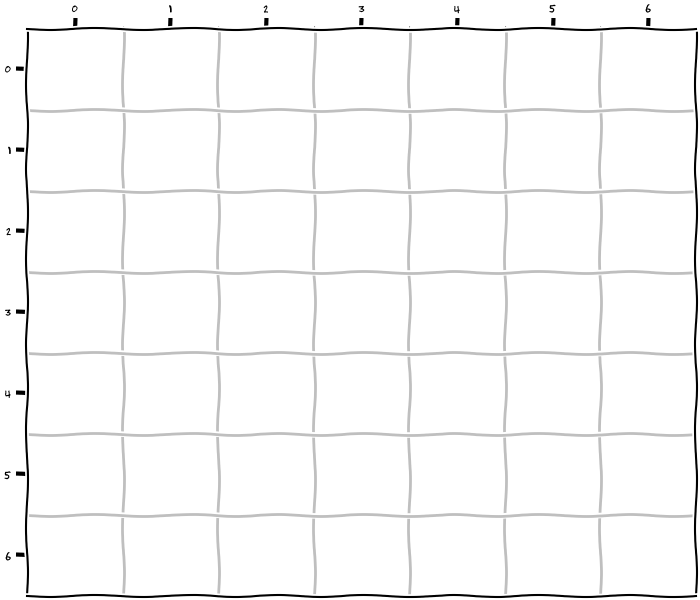

In [3]:
# to_remove solution

with plt.xkcd():
  fig, ax = make_grid(7, 7)
  plt.show()

*Bonus: see where the actual code is:*

Find and tweak the make_grid function in the setup cell above to make the grid lines green. Where is the make_grid function defined?

Wow, what a boring environment. Let's add an organism and something for that organism to interact with. We'll start with 10 food items scattered randomly throughout the grid, never more than one food item per grid cell. To plot these food items we need their locations. We will set these by randomly sampling grid coordinates [without replacement](## "never picking the same (row,col) coordinate pair twice"). We'll place the organism in the same way and not on a food item to start.

In [4]:
################################################################################
# TODO for students: Replace ... in init_loc(...) to initialize the right
# number of food item locations and critter locations in coordinates that make
# sense for our grid environment. Then replace the ... in rc_plotting[...] to
# index the plotting coordinates for the food locations.
# Hint: The syntax for indexing elements of numpy arrays using [] can be
# confusing at first. If you're lost read the docs,
# https://numpy.org/doc/stable/user/basics.indexing.html and add some code
# cells below to play around with indexing and displaying different sub-arrays
# of the rc_plotting array.
# Comment out or remove this next lines.
raise NotImplementedError("Exercise: initialize food and critter locations")
################################################################################


def init_loc(n_rows, n_cols, num, rng=None):
  """
  Samples random 2d grid locations without replacement

  Args:
    n_rows: int
    n_cols: int
    num:    int, wnumber of samples to generate, should
            throw an error ifnum <= n_rows x n_cols

  Optional Keyword Args
    rng:    instance of numpy.random's default random number generator
            (to enable reproducability)

  Returns:
    int_loc:  ndarray(int) of flat indices for the grid
    rc_index: (ndarray(int), ndarray(int)) a pair of arrays the first
      giving the row indices, the second giving the col indices, useful
      for indexing an n_rows by n_cols numpy array
    rc_plotting: ndarray(int) num x 2, same rc coordinates but structured
      in a way that matplotlib likes
  """
  if rng is None:
    rng = np.random.default_rng(seed=SEED)
  int_loc = rng.choice(n_rows * n_cols, num, replace=False)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  rc_plotting = np.array(rc_index).T
  return int_loc, rc_index, rc_plotting

fig, ax = make_grid(7, 7)
int_locs, rc_index, rc_plotting = init_loc(..., ..., ...)

rc_critter = (rc_plotting[0])
plot_critter(fig, ax, rc_critter)

rc_food = rc_plotting[...]
plot_food(fig, ax, rc_food)

fig.legend(loc='outside right upper')
plt.show()

NotImplementedError: ignored

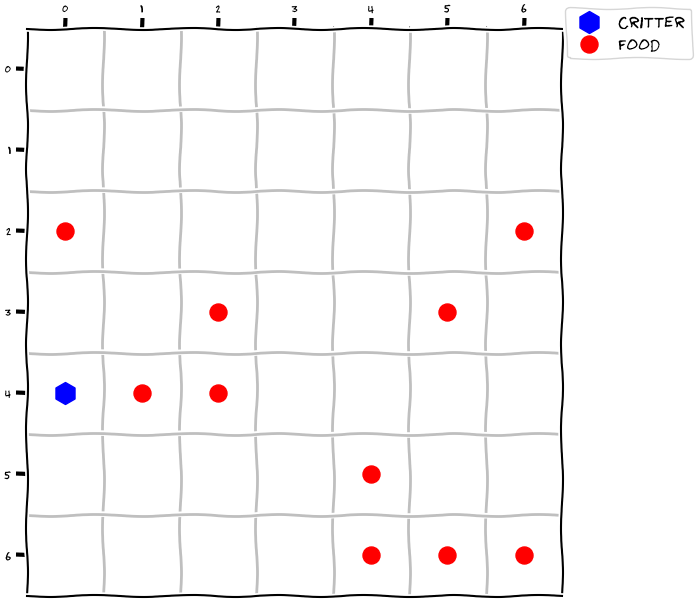

In [5]:
#to_remove solution


def init_loc(n_rows, n_cols, num, rng=None):
  """
  Samples random 2d grid locations without replacement

  Args:
    n_rows: int
    n_cols: int
    num:    int, wnumber of samples to generate, should
            throw an error ifnum <= n_rows x n_cols
  Optional Keyword Args
    rng:    instance of numpy.random's default rng (reproducability)

  Returns:
    int_loc: ndarray(int) of flat indices for a grid
    rc_index: (ndarray(int), ndarray(int)) a pair of arrays the first
      giving the row indices, the second giving the col indices, useful
      for indexing an n_rows by n_cols numpy array
    rc_plotting: ndarray(int) num x 2, same rc coordinates but structured
      in the way that matplotlib likes
  """
  if rng is None:
    rng = np.random.default_rng(seed=SEED)
  int_loc = rng.choice(n_rows * n_cols, num, replace=False)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  rc_plotting = np.array(rc_index).T
  return int_loc, rc_index, rc_plotting


with plt.xkcd():
  fig, ax = make_grid(7, 7)
  int_locs, rc_index, rc_plotting = init_loc(7, 7, 11)

  rc_critter = (rc_plotting[0])
  plot_critter(fig, ax, rc_critter)

  rc_food = rc_plotting[1:]
  plot_food(fig, ax, rc_food)

  fig.legend(loc='outside right upper')
  plt.show()

In [6]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_M1")

---
# 1.1.1.2: Random Eating

Now that we have an environment scattered with food and an organism, let's introduce some behaviour. The organism drifts around the environment randomly and eats the food it happens to stumble upon. (Can you think of any organisms that employ this strategy? [hint](## "think about the way very very small biological things move around")). When food is eaten, the organism gets a **reward**, in this case a *Food Eaten* point, and a new food item appears randomly somewhere else in the environment (that doesn't already have food). Run the code cell below to see what this looks like.

In [7]:
# @title Random Movement
# @markdown Don't worry about how this code works – just **run this cell** then click the start button and watch what happens.

rng = np.random.default_rng(seed=420)
gwg = GridworldGame(1, 7, 7, 10, 30, rng=rng)
random_igwg = InteractiveGridworld(gwg)
display(random_igwg.b_fig.canvas)
clear_output()
display(random_igwg.board_output_score_start)

*Question:* When the organism is just drifting around randomly how good is it at eating lots of food, what is its efficiency in terms of food per movement? Now click the start button again and run the simulation a few more times. Does the organism always eat the same amount of food or does it change between simulation runs? [explanation](## "The amount of food eaten varies from simulation run to simulation run,usually the organism manages to eat one or two or three pieces of food, sometimes more
sometimes less.")

*Bonus: see how the effectiveness of a strategy depens on the environment:*

Before we move on it's important to test that our simulation is running as we expect. Randomness can make testing hard, but can be overcome in part by setting up the environment in such a way that the outcome becomes deterministic. In the code cells bellow change how the Gridworld is initialized. By altering the size, shape and number of food items available create a scenario where the organism will always achieve perfect efficiency and a scenario where the organism will fail completely.

We will do this here by either providing food everywhere or nowhere.

In [8]:
###############################################################################
# TODO for students: Replace the ...'s in GridworldGame(...) to initialize a
# Gridworld where the organism is always 100% efficient. Food. Everywhere.
raise NotImplementedError("Exercise: make random movement 100% efficient")
################################################################################

gwg = GridworldGame(1, ..., ..., ..., 30)
random_igwg_100 = InteractiveGridworld(gwg)
display(random_igwg_100.b_fig.canvas)
clear_output()
display(random_igwg_100.board_output_score_start)

NotImplementedError: ignored

In [9]:
#to_remove solution
gwg = GridworldGame(1, 2, 2, 3 , 30)
random_igwg_100 = InteractiveGridworld(gwg)
display(random_igwg_100.b_fig.canvas)
clear_output()
display(random_igwg_100.board_output_score_start)

Ok. We have just seen a super successful (albeit completely dumb) organism. Lets see if we can have an environment where any organism would fail (maybe surprisingly intelligence can not make food out of nothing).

In [10]:
###############################################################################
# TODO for students: Replace the ...'s in GridworldGame(...) to initialize a
# Gridworld where the organism is always 0% efficient.
raise NotImplementedError("Exercise: make random movement 0% efficient")
################################################################################

gwg = GridworldGame(1, ..., ..., ..., 30)
random_igwg_0 = InteractiveGridworld(gwg)
display(random_igwg_0.b_fig.canvas)
clear_output()
display(random_igwg_0.board_output_score_start)

NotImplementedError: ignored

In [11]:
#to_remove solution
gwg = GridworldGame(1, 2, 2, 0, 30)
random_igwg_0 = InteractiveGridworld(gwg)
display(random_igwg_0.b_fig.canvas)
clear_output()
display(random_igwg_0.board_output_score_start)

In [12]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_M2")

---
# 1.1.1.3: Better Than Random Eating
Now it's your turn to actually control the organism with some level of intelligence (give it your all). Run the next cell and see how much more efficient than random drifting your control of the organism is in terms of food per movement. Does intelligence help?

In [13]:
# @title Controlled Movement
# @markdown Don't worry about how this code works – just **run the cell** and then use the buttons to guide the organism

# user in control
gwg = GridworldGame(2, 7, 7, 10, 30,
                    rng=np.random.default_rng(seed=9))
h2h_igwg = Head2HeadGridworld(gwg)
display(h2h_igwg.b_fig0.canvas)
display(h2h_igwg.b_fig1.canvas)
display(h2h_igwg.b_fig_legend.canvas)
clear_output()
display(h2h_igwg.boards_and_scores)

Hopefully your performance was more successful than random flailing (if not, reset to the safe point). Even in this relatively simple and contrived foraging scenario intelligence can help a lot. What kinds of strategies and heuristics did you use to guide your choice of direction? A fundamental purpose of nervous systems and brains is to solve problems of this kind—chosing which actions to take based on environmental inputs to maximize rewards.

In [14]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_M3")

---
#1.1.1.4: Optimized Eating


Let's welcome a special guest, GW7x7-10-30, from the final chapter of this book. Utilizing a blend of deep reinforcement learning and Monte-Carlo search based on the AlphaZero optimization algorithm, GW7x7-10-30 has achieved mastery of the 7x7 Gridworld environment, with 10 food items and a game duration of 30 rounds.

The AlphaZero optimization algorithm finds inspiration from our understanding of the brain, and also draws upon various concepts from machine learning. As such, our specific computer implementation of the algorithm is unlikely to mirror the learning algorithms used by the brain in any particular detail.

Despite this lack of immediate correspondence, we can still gain significant insight by identifying the generalized form of learning problems that the brain solves together with the classes of optimization algorithms capable of feasibly solving these learning problems subject to biological constraints. These constraints derive from a multitude of factors based on the evolution, ecology, physiology, development, etc, of the organism. These insights will enable us to deduce the most probable types of learning algorithms employed by brains.

Subsequently, these deductions can guide us in seeking out the specific mechanisms and intricate details of the learning algorithms found in brains. Throughout this book, we will focus on introducing the general learning problems encountered by living organisms. We will identify different machine learning techniques that can presently solve these problems under various conditions. Furthermore, we will link the feasible machine learning solutions of these broader learning problems to our current empirical understanding of how a brain might implement similar solutions.

Our aim with this approach is to foster a principled, systematic, and integrative groundwork for neuroscience research. Now, let's run the next cells to see who is more efficient – you or GW7x7-10-30. Reading this book will empower you to design the next generation of GW7x7-10-30.


In [15]:
# @title Optimized Movement
# @markdown Don't worry about how this code works – **run this cell** to set up the superorganism and an environment for it and you. Note, the superorganism will be **slow** to compute its moves if GPU accelleration is not enabled for this runtime. If possible, in the menu under `Runtime` -> "`Change runtime type`  select `GPU`.

# initialize the game, network, and MonteCarlo player
gwg = GridworldGame(1, 7, 7, 10, 30)
pvnetMC = PolicyValueNetwork(gwg)
mcp = MonteCarloBasedPlayer(gwg, pvnetMC, default_depth=3,
                            default_rollouts=80, default_temp=0.02)


#grab the saved model from the repo or where it ends up being hosted
url = "https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/sequences/P1C1_BehaviourAsPolicy/data/pvnetMC.pth.tar"
r = requests.get(url)

if r.status_code == 200:
  filename = os.path.basename(url)
  # Write the contents to a file in the current working directory
  with open(filename, 'wb') as file:
    file.write(r.content)
    #print(f'{filename} downloaded successfully.')
else:
  print('Error occurred while downloading the file.')

# load the saved model
pvnetMC.load_checkpoint(folder=os.getcwd(), filename='pvnetMC.pth.tar')

# user in control versus mc player
gwg = GridworldGame(2, 7, 7, 10, 30,
                    rng=np.random.default_rng(seed=2000))
h2h_igwg = Head2HeadGridworld(gwg, player=mcp)
display(h2h_igwg.b_fig0.canvas)
display(h2h_igwg.b_fig1.canvas)
display(h2h_igwg.b_fig_legend.canvas)
clear_output()
display(h2h_igwg.boards_and_scores)

Who was more efficient in this environment you or gw7x7-10-30? If gw7x7-10-30 was better, you really have read this book 😉 (If you can't beat the AIs, at least learn how to program them.) Even if you were about as good as gw7x7-10-30 you still might want to read this book. A deep understanding of the optimization processes that shape behaviour in simple organism-environment systems like this one will allow for generalizition to more intricate systems, specifically, a rich understanding of how brains generate adaptive behaviour as a result of optimzation processes.

In [16]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_M4")

---
# Comprehension Quiz

In [17]:
# @title Quiz
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
{
  "question": "What does a policy represent in the context of behaviour?",
  "type": "multiple_choice",
  "answers": [
  {
    "answer": "The evolutionary history of an organism",
    "correct": False,
    "feedback": "This is true in a broad and abstract sense, but there is a more precise answer here."
  },
  {
    "answer": "The environment in which an organism lives",
    "correct": False,
    "feedback": "There is a sense in which a policy shaped by evolution can reflect aspects of an organism's environment, but there is a more precise answer here."
  },
  {
    "answer": "The formal description of behaviour as a function that maps experiences to actions",
    "correct": True,
    "feedback": "Correct."
  },
  {
    "answer": "The randomness present in an organism's behavior",
    "correct": False,
    "feedback": "The policy might have randomness in it, but that's not what it is."
  }]
},
{
  "question": "How is a policy evaluated in terms of its goodness?",
  "type": "multiple_choice",
  "answers": [
  {
    "answer": "By integrating rewards and environmental signals into a loss/objective function",
    "correct": True,
    "feedback": "Corret, 'goodness' needs to be formalized in a loss/objective funtion"
  },
  {
    "answer": "By measuring the organism's fitness in the environment",
    "correct": True,
    "feedback": "This is one important way of evaluating a policy, but there is a more generally correct answer here."
  },
  {
    "answer": "By determining the amount of randomness present in the policy",
    "correct": False,
    "feedback": "Incorrect."
  },
  {
    "answer": "By analyzing the organism's evolutionary adaptations",
    "correct": False,
    "feedback": "Incorrect."
  }]
},
{
  "question": "What is stochasticity in the context of behaviour?",
  "type": "multiple_choice",
  "answers": [
    {
      "answer": "The specific niche an organism occupies within its environment",
      "correct": False,
      "feedback": "Incorrect."
    },
    {
      "answer": "The ability of an organism to adapt to changing environmental conditions",
      "correct": False,
      "feedback": "Incorrect."
    },
    {
      "answer": "The random elements present in both the environment and an organism's behavior",
      "correct": True,
      "feedback": "Correct."
    },
    {
      "answer": "The process of optimizing a policy to achieve better outcomes",
      "correct": False,
      "feedback": "Incorrect."
    }]
  },
  {
    "question": "What is the main difference between random eating and controlled movement in the environment?",
    "type": "multiple_choice",
    "answers": [
    {
      "answer": "Random eating involves unpredictable movements, while controlled movement can be planned and strategic.",
      "correct": True,
      "feedback": "Correct."
    },
    {
      "answer": "Random eating leads to higher efficiency, while controlled movement leads to lower efficiency.",
      "correct": False,
      "feedback": "Incorrect."
    },
    {
      "answer": "Random eating relies on external cues, while controlled movement relies on internal motivations.",
      "correct": False,
      "feedback": "Incorrect."
    },
    {
      "answer": "Random eating results in adaptive behavior, while controlled movement leads to stagnation.",
      "correct": False,
      "feedback": "Incorrect."
    }]
  },
  {
    "question": "What is the significance of GW7x7-10-30 in the context of optimized eating?",
    "type": "multiple_choice",
    "answers": [
    {
      "answer": "It represents a time-traveling superorganism with advanced cognitive abilities.",
      "correct": False,
      "feedback": "Incorrect."
    },
    {
      "answer": "It demonstrates the limitations of optimized behavior in a simple environment.",
      "correct": True,
      "feedback": "It could serve this purpose, though that wasn't the main reason we introduced it here."
    },
    {
      "answer": "It showcases the potential efficiency achievable through optimized behavior.",
      "correct": True,
      "feedback": "Correct."
    },
    {
      "answer": "It serves as a benchmark for comparing different organisms' performance.",
      "correct": True,
      "feedback": "It could serve this purpose, though that wasn't the main reason we introduced it here."
    }]
  }
]


display_quiz(comprehension_quiz)

<IPython.core.display.Javascript object>